In [161]:
%pwd

u'/Users/firas/Box Sync/Home Folder fsm3/Sync/schmid/data.plus.code/_mcmc_sampler'

In [162]:
from scipy.io import loadmat
from textwrap import wrap

import pandas as pd, \
       numpy  as np, \
       matplotlib.pyplot as plt, \
       seaborn as sns, \
       math
        
%matplotlib inline

#### Auxiliary functions needed for analysis

In [163]:
def summ_S(S):
    #computes cumulative variance explained by prinicipal components given an eigenvlaues list
    var_exp=[];
    for i in range(U.shape[1]):
        var_exp.append(float(np.sum(S[0:i+1]))/np.sum(S))
    num_pcs  = np.where(np.array(var_exp)>0.90)[0][0];  
    return var_exp,num_pcs 

def varimax(Phi, gamma = 1, q = 20, tol = 1e-6):
    #rotates principal components given a loading matrix (Phi)
    #author: https://en.wikipedia.org/wiki/Talk%3AVarimax_rotation
    from numpy import eye, asarray, dot, sum, diag
    from numpy.linalg import svd
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in xrange(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d/d_old < tol: break
    return dot(Phi, R)

###Find index for biomass turnover flux in FBA model 

In [164]:
rxns          = pd.read_csv('../_model_definition/transitionIds.txt',sep='\t',header=None,index_col=None)
rxn_ids       = [x.strip() for x in np.ravel(rxns.values)];
biomass_index = np.where([rxn_ids[x]=='ER90000' for x in range(len(rxn_ids))])[0][0]
biomass_index

660

### Load PROM-FBA model (from matlab variable)

In [165]:
matlab = loadmat('../_main_scripts/_output/PROM_HaloS_output.mat');
v0_all = matlab['v0_all']
v_all  = matlab['v_all']

halos = pd.read_csv('../_model_definition/gonzalez_midani_reconstruction_2015_08_16.txt',sep='\t',header=0,index_col=0).fillna('')

### Load wild-type and knock-out sampling results

In [166]:
wt_sampling   = loadmat('../_mcmc_sampler/tp-7/tp-7_wt.mat');
mat_struct    = wt_sampling['sampleStructOut']
val           = mat_struct[0,0]
wt_sampling   = {};

for field in val.dtype.fields.keys():
    if not field[0:2]=='__':
        wt_sampling[field] = val[field];
        
wtSamples = wt_sampling['points'];
wtSamples = wtSamples[0:780]

In [167]:
ko_sampling   = loadmat('../_mcmc_sampler/tp-7/tp-7_delta_trmb.mat');
mat_struct    = ko_sampling['sampleStructOut']
val           = mat_struct[0,0]
ko_sampling   = {};

for field in val.dtype.fields.keys():
    if not field[0:2]=='__':
        ko_sampling[field] = val[field];
        
koSamples = ko_sampling['points'];
koSamples = koSamples[0:780];

### Perform Singular Value Decomposition on wild-type model 

(780, 780) (780,) (5000, 5000)
[0.55700215650309981, 0.66709523877859267, 0.74991013976691856, 0.82178735094984656, 0.87849955239033439, 0.9292739466140848, 0.96413068917566891, 0.99496127866890383, 0.99589728918490195, 0.99630293577374662, 0.99666617575377459, 0.99699070131070089, 0.99719837613854501, 0.99734726514351946, 0.99747521083106672, 0.99758218146649769, 0.99768296856802996, 0.99777045203499881, 0.99785507772299997, 0.99793405526890555, 0.99800910257888442, 0.99808079209192524, 0.99814952727549899, 0.99821606146791442, 0.9982801692025377, 0.99834183848028291, 0.99840034808089817, 0.99845838291255928, 0.99851408741376668, 0.99856479858425318, 0.99861436203916532, 0.9986620051623325, 0.99870759684892207, 0.9987526050976101, 0.99879534790255775, 0.99883681649328449, 0.99887550365472766, 0.99891359928469681, 0.99895120516413738, 0.99898878245439926, 0.99902537792018054, 0.99906059016870941, 0.99909438346959145, 0.99912629544413578, 0.99915710557974213, 0.99918521442639252, 0.9992

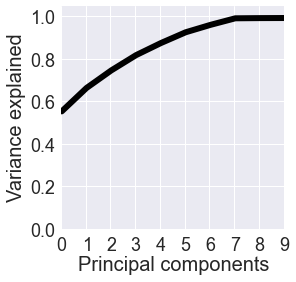

In [176]:
sns.set()

U,S,V = np.linalg.svd((wtSamples));
var_exp,num_pcs = summ_S(S)
top_pcs         = S[0:num_pcs];
rU  = varimax(U[:,0:num_pcs*2]);
fig = plt.figure(figsize=[4,4])
plt.plot(var_exp[0:num_pcs*2],color='black',lw=6);
plt.ylim([0,1.05])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Variance explained',fontsize=20)
plt.xlabel('Principal components',fontsize=20)
print U.shape, S.shape, V.shape
print var_exp

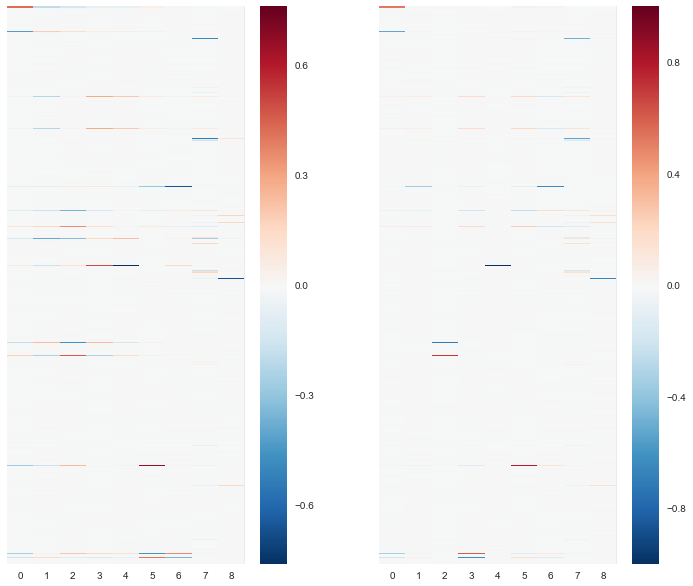

In [169]:
import seaborn as sns
sns.set()

fig, axs = plt.subplots(1,2, figsize=(12,10), facecolor='w', edgecolor='k')#,sharex='column')
fig.subplots_adjust(hspace = .15, wspace=0.25)

sns.heatmap( U[:,1:2*num_pcs],ax=axs[0])
sns.heatmap(rU[:,1:2*num_pcs],ax=axs[1])

for i in range(len(axs)):
    axs[0].set_yticks([])
    axs[1].set_yticks([])


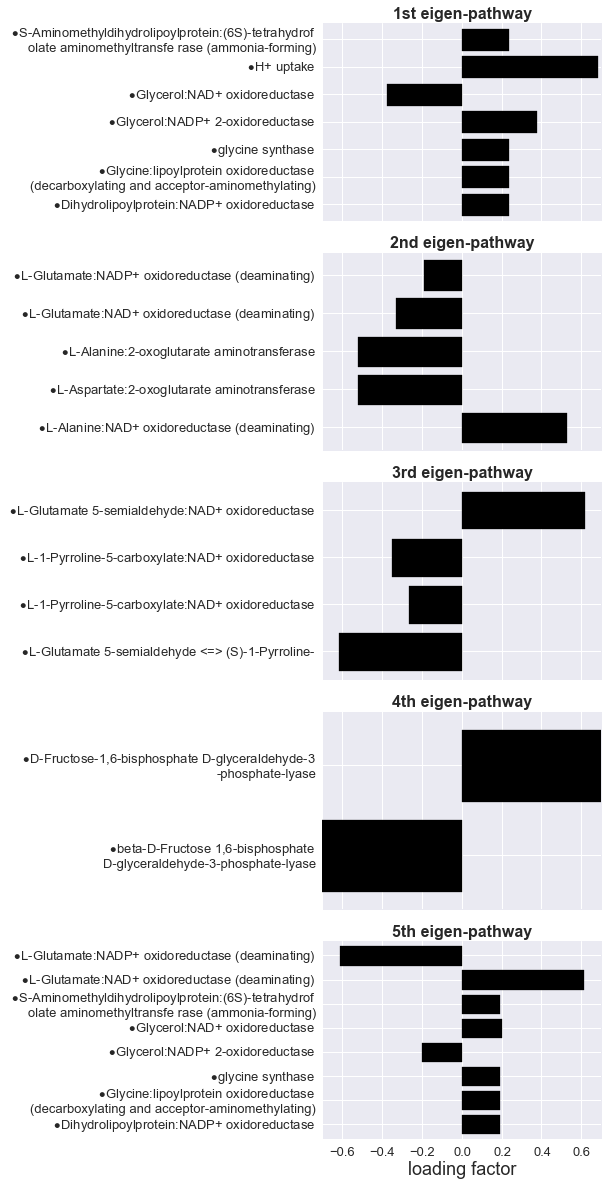

In [170]:
sns.set()

fig, axs = plt.subplots(len(top_pcs),1, figsize=(5,20), facecolor='w', edgecolor='k',sharex='column')
fig.subplots_adjust(hspace = .16, wspace=0.25)

axs = axs.ravel()

prefix_dict={0:'1st',1:'2nd',2:'3rd'};

for i in range(len(top_pcs)): 
        max_loading= np.max(abs(rU[:,i]));
        toplot     = np.where(abs(rU[:,i])>0.25*max_loading)[0]
        U_subset   = rU[toplot,i]
        top_var_rxns_ids = [rxns.iloc[rr,0].rstrip() for rr in toplot]
        shortnames = np.array([halos.loc[j,"name"] for j in top_var_rxns_ids])
        longnames  = np.array([halos.loc[j,"reaction_using_names"] for j in top_var_rxns_ids])
        shortnames[np.where(shortnames=='')[0]]=longnames[np.where(shortnames=='')[0]]

        if i<3:
            prefix=prefix_dict[i];
        else:
            prefix=str(i+1)+'th'
        axs[i].barh(range(U_subset.shape[0]),U_subset,color='black',height=0.8)
        axs[i].set_title(prefix+' eigen-pathway',fontsize=16,fontweight='bold')
        axs[i].tick_params(axis='x',labelsize=13)
        axs[i].tick_params(axis='y',labelsize=13)

        labels = [ r'$\bullet$'+'\n'.join(wrap(l, 50)) for l in shortnames]
        bound = math.ceil(np.max(abs(U_subset))*10)*0.1
        axs[i].set_yticks([0.4+ww for ww in range(U_subset.shape[0])])#,rotation=90)
        axs[i].set_yticklabels(labels,rotation=0)
        
        axs[i].grid()
        axs[i].set_xlim([-1*bound,bound])
        axs[i].set_ylim([-0.2,U_subset.shape[0]])
        axs[i].grid()
axs[i].set_xlabel('loading factor',fontsize=18)
plt.savefig('../_mcmc_sampler/tp-7/tp-7_wt_pcs.pdf', format='pdf', dpi=1000)




###knockout SVD

(780, 780) (780,) (5000, 5000)
[0.5862474362441833, 0.68294459280497088, 0.76676399769907366, 0.82949327011469076, 0.88490407931915949, 0.93078743437263711, 0.97111164769053082, 0.99997044327046003, 0.99997496238549111, 0.99997733863898575, 0.9999796914523772, 0.9999817708663763, 0.99998290069530993, 0.99998377428581287, 0.99998454318659002, 0.99998528678269272, 0.99998587182575438, 0.99998642713170316, 0.99998690313021066, 0.99998736452385262, 0.99998781785656932, 0.99998825410354297, 0.99998866953414411, 0.9999890723243845, 0.9999894554216785, 0.99998981734634518, 0.99999015553040582, 0.99999048115410238, 0.99999080271195251, 0.99999111491955084, 0.99999140878874893, 0.99999169288567757, 0.99999195926185436, 0.99999222226454132, 0.99999247753904907, 0.99999272512925208, 0.99999296264002602, 0.99999319810015763, 0.9999934291853011, 0.9999936443083155, 0.99999385371082405, 0.99999406154487414, 0.99999426146006665, 0.99999445418954869, 0.99999463073008243, 0.9999947966270728, 0.99999495

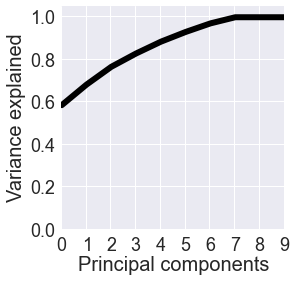

In [175]:
U,S,V = np.linalg.svd((koSamples));
var_exp,num_pcs = summ_S(S)
top_pcs         = S[0:num_pcs];
rU  = varimax(U[:,0:num_pcs*2]);
fig = plt.figure(figsize=[4,4])
plt.plot(var_exp[0:num_pcs*2],color='black',lw=6);
plt.ylim([0,1.05])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Variance explained',fontsize=20)
plt.xlabel('Principal components',fontsize=20)
print U.shape, S.shape, V.shape
print var_exp

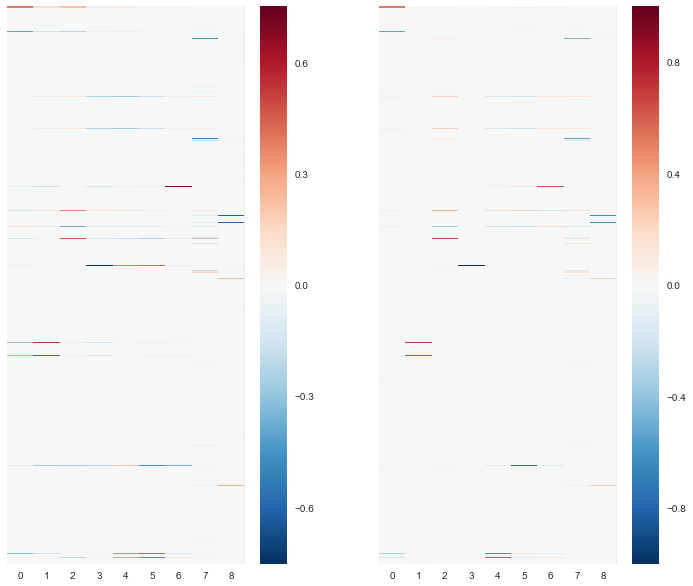

In [172]:
import seaborn as sns
sns.set()

fig, axs = plt.subplots(1,2, figsize=(12,10), facecolor='w', edgecolor='k')#,sharex='column')
fig.subplots_adjust(hspace = .15, wspace=0.25)

sns.heatmap( U[:,1:2*num_pcs],ax=axs[0])
sns.heatmap(rU[:,1:2*num_pcs],ax=axs[1])

for i in range(len(axs)):
    axs[0].set_yticks([])
    axs[1].set_yticks([])



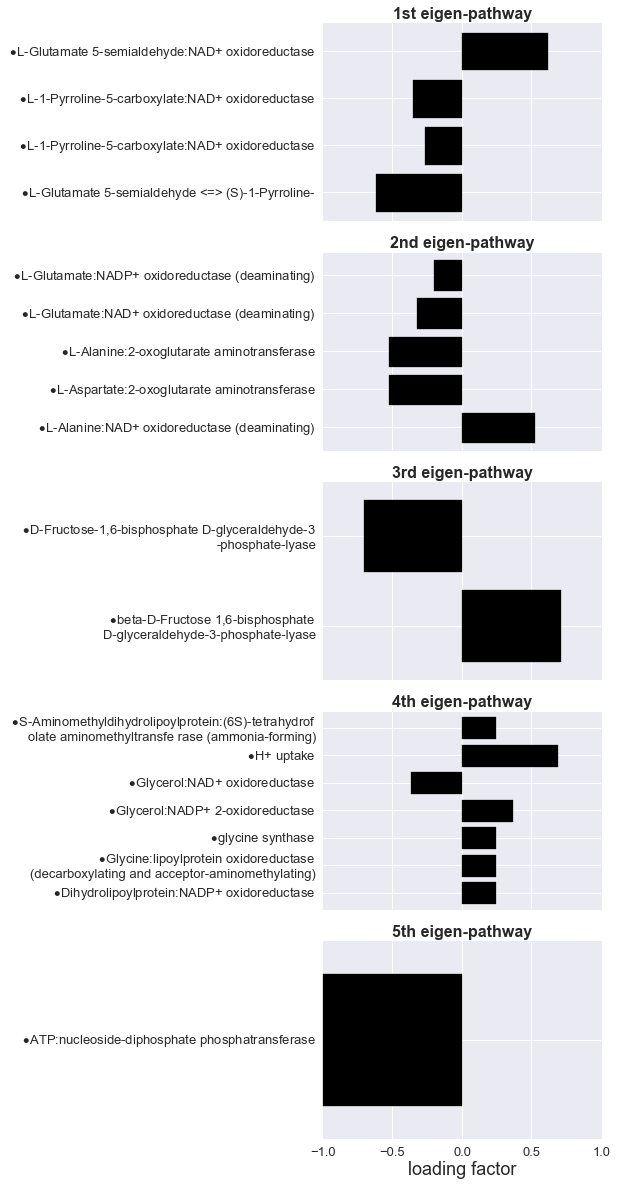

In [173]:
sns.set()

fig, axs = plt.subplots(len(top_pcs),1, figsize=(5,20), facecolor='w', edgecolor='k',sharex='column')
fig.subplots_adjust(hspace = .16, wspace=0.25)

axs = axs.ravel()

prefix_dict={0:'1st',1:'2nd',2:'3rd'};

for i in range(len(top_pcs)): 
        max_loading= np.max(abs(rU[:,i]));
        toplot     = np.where(abs(rU[:,i])>0.25*max_loading)[0]
        U_subset   = rU[toplot,i]
        top_var_rxns_ids = [rxns.iloc[rr,0].rstrip() for rr in toplot]
        shortnames = np.array([halos.loc[j,"name"] for j in top_var_rxns_ids])
        longnames  = np.array([halos.loc[j,"reaction_using_names"] for j in top_var_rxns_ids])
        shortnames[np.where(shortnames=='')[0]]=longnames[np.where(shortnames=='')[0]]

        if i<3:
            prefix=prefix_dict[i];
        else:
            prefix=str(i+1)+'th'
        axs[i].barh(range(U_subset.shape[0]),U_subset,color='black',height=0.8)
        axs[i].set_title(prefix+' eigen-pathway',fontsize=16,fontweight='bold')
        axs[i].tick_params(axis='x',labelsize=13)
        axs[i].tick_params(axis='y',labelsize=13)

        labels = [ r'$\bullet$'+'\n'.join(wrap(l, 50)) for l in shortnames]
        bound = math.ceil(np.max(abs(U_subset))*10)*0.1
        axs[i].set_yticks([0.4+ww for ww in range(U_subset.shape[0])])#,rotation=90)
        axs[i].set_yticklabels(labels,rotation=0)
        
        axs[i].grid()
        axs[i].set_xlim([-1*bound,bound])
        axs[i].set_ylim([-0.2,U_subset.shape[0]])
        axs[i].grid()
axs[i].set_xlabel('loading factor',fontsize=18)
plt.savefig('../_mcmc_sampler/tp-7/tp-7_wt_pcs.pdf', format='pdf', dpi=1000)



